<a href="https://colab.research.google.com/github/pritesh604/AVMLA_Project_IAE/blob/master/Data_loader(nuscenes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2021-07-24 08:13:06--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.224.7.115, 13.224.7.63, 13.224.7.111, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.224.7.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G  33.4MB/s    in 1m 57s  

2021-07-24 08:15:04 (33.9 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [41]:
from nuscenes.utils.data_classes import RadarPointCloud, Box
from nuscenes.utils.geometry_utils import box_in_image, view_points, BoxVisibility, points_in_box
import numpy as np

import matplotlib.pyplot as plt
import sys
import os
import os.path as osp
from PIL import Image

In [3]:
channels = ['RADAR_FRONT','CAM_FRONT']


# **CAMERA DATA**

In [4]:

def create_annotations(self, sample_token, sensor_channels):
        """
        Create annotations for the the given sample token.
        1 bounding box vector contains:
        :param sample_token: the sample_token to get the annotation for
        :param sensor_channels: list of channels for cropping the labels, e.g. ['CAM_FRONT', 'RADAR_FRONT']
            This works only for CAMERA atm
        :returns: 
            annotations dictionary:
            {
                'labels': [] # <list of n int>  
                'bboxes': [] # <list of n x 4 float> [xmin, ymin, xmax, ymax]
                'distances': [] # <list of n float>  Center of box given as x, y, z.
                'visibilities': [] # <list of n float>  Visibility of annotated object
            }
        """

        if any([s for s in sensor_channels if 'RADAR' in s]):
            print("[WARNING] Cropping to RADAR is not supported atm")
            sensor_channels = [c for c in sensor_channels if 'CAM' in sensor_channels]

        sample = self.nusc.get('sample', sample_token)
        annotations_count = 0
        annotations = {
            'labels': [], # <list of n int>  
            'bboxes': [], # <list of n x 4 float> [xmin, ymin, xmax, ymax]
            'distances': [], # <list of n float>  Center of box given as x, y, z.
            'visibilities': [],
            'num_radar_pts':[] #<list of n int>  number of radar points that cover that annotation
            }

        # Camera parameters
        for selected_sensor_channel in sensor_channels:
            sd_rec = self.nusc.get('sample_data', sample['data'][selected_sensor_channel])

            # Create Boxes:
            _, boxes, camera_intrinsic = self.nusc.get_sample_data(sd_rec['token'], box_vis_level=BoxVisibility.ANY)
            imsize_src = (sd_rec['width'], sd_rec['height']) # nuscenes has (width, height) convention
            
            bbox_resize = [ 1. / sd_rec['height'], 1. / sd_rec['width'] ]
            if not self.normalize_bbox:
                bbox_resize[0] *= float(self.image_min_side)
                bbox_resize[1] *= float(self.image_max_side)

            # Create labels for all boxes that are visible
            for box in boxes:

                # Add labels to boxes 
                if box.name in self.classes:
                    box.label = self.classes[box.name]
                    # Check if box is visible and transform box to 1D vector
                    if box_in_image(box=box, intrinsic=camera_intrinsic, imsize=imsize_src, vis_level=BoxVisibility.ANY):
                        
                        ## Points in box method for annotation filterS
                        # check if bounding box has an according radar point
                        if self.only_radar_annotated == 2:

                            pcs, times = RadarPointCloud.from_file_multisweep(self.nusc, sample, self.radar_sensors[0], \
                                selected_sensor_channel, nsweeps=self.n_sweeps, min_distance=0.0, merge=False)

                            for pc in pcs:
                                pc.points = radar.enrich_radar_data(pc.points)    

                            if len(pcs) > 0:
                                radar_sample = np.concatenate([pc.points for pc in pcs], axis=-1)
                            else:
                                print("[WARNING] only_radar_annotated=2 and sweeps=0 removes all annotations")
                                radar_sample = np.zeros(shape=(len(radar.channel_map), 0))
                            radar_sample = radar_sample.astype(dtype=np.float32)

                            mask = points_in_box(box, radar_sample[0:3,:])
                            if True not in mask:
                                continue 


                        # If visible, we create the corresponding label
                        box2d = box.box2d(camera_intrinsic) # returns [xmin, ymin, xmax, ymax]
                        box2d[0] *= bbox_resize[1]
                        box2d[1] *= bbox_resize[0]
                        box2d[2] *= bbox_resize[1]
                        box2d[3] *= bbox_resize[0]

                        annotations['bboxes'].insert(annotations_count, box2d)
                        annotations['labels'].insert(annotations_count, box.label)
                        annotations['num_radar_pts'].insert(annotations_count, self.nusc.get('sample_annotation', box.token)['num_radar_pts'])

                        distance =  (box.center[0]**2 + box.center[1]**2 + box.center[2]**2)**0.5
                        annotations['distances'].insert(annotations_count, distance)
                        annotations['visibilities'].insert(annotations_count, int(self.nusc.get('sample_annotation', box.token)['visibility_token']))
                        annotations_count += 1
                else:
                    # The current name has been ignored
                    pass

        annotations['labels'] = np.array(annotations['labels'])
        annotations['bboxes'] = np.array(annotations['bboxes'])
        annotations['distances'] = np.array(annotations['distances'])
        annotations['num_radar_pts'] = np.array(annotations['num_radar_pts'])
        annotations['visibilities'] = np.array(annotations['visibilities'])

        # num_radar_pts mathod for annotation filter
        if self.only_radar_annotated == 1:

            anns_to_keep = np.where(annotations['num_radar_pts'])[0]

            for key in annotations:
                annotations[key] = annotations[key][anns_to_keep]

        return annotations

In [12]:
from nuscenes.nuscenes import NuScenes 
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.603 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [14]:
my_scene = nusc.scene[0]
my_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample',my_sample_token)


In [17]:
cam_data = nusc.get('sample_data',my_sample['data']['CAM_FRONT'])
_,boxes,camera_intrinsic = nusc.get_sample_data(cam_data['token'],box_vis_level = BoxVisibility.ANY)               
imsize_src = (cam_data['width'], cam_data['height'])

In [19]:
bbox_resize = [ 1. / cam_data['height'], 1. / cam_data['width'] ]
image_min_side = 900
image_max_side = 1000
normalize_bbox = False

if not normalize_bbox:
                bbox_resize[0] *= float(image_min_side)
                bbox_resize[1] *= float(image_max_side)

In [22]:
classes = ['pedestrian', 'car', 'bicycle']
search_classes = ['human.pedestrian.adult','vehicle.car','vehicle.bicycle']

In [23]:
def enrich_radar_data(radar_data):
    """
    This function adds additional data to the given radar data
    
    :param radar_data: The source data which are used to calculate additional metadata
        Semantics: x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0
    :returns enriched_radar_data:
            [0]: x
            [1]: y
            [2]: z
            [3]: dyn_prop
            [4]: id
            [5]: rcs
            [6]: vx
            [7]: vy
            [8]: vx_comp
            [9]: vy_comp
            [10]: is_quality_valid
            [11]: ambig_state
            [12]: x_rms
            [13]: y_rms
            [14]: invalid_state
            [15]: pdh0
            [16]: vx_rms
            [17]: vy_rms
            [18]: distance
            [19]: azimuth
            [20]: vrad_comp
    """
   

    # Adding distance
    # Calculate distance
    dist = np.sqrt(radar_data[0]**2 + radar_data[1]**2)
    dist = np.expand_dims(dist, axis=0)

    # calculate the azimuth values
    azimuth = np.arctan2(radar_data[1], radar_data[0]) 
    azimuth = np.expand_dims(azimuth, axis=0)

    # Calculate vrad comp
    radial = np.array([radar_data[0], radar_data[1]]) # Calculate the distance vector
    radial = radial / np.linalg.norm(radial, axis=0, keepdims=True)# Normalize these vectors
    v = np.array([radar_data[8], radar_data[9]]) # Create the speed vector
    vrad_comp = np.sum(v*radial, axis=0, keepdims=True) # Project the speed component onto this vector

    data_collections = [
        radar_data,
        dist,
        azimuth,
        vrad_comp
    ]

    enriched_radar_data = np.concatenate(data_collections, axis=0)

    return enriched_radar_data

In [25]:
only_radar_annotated = 2

In [ ]:
for box in boxes:
  print(box.name)

In [142]:
annotations = {
            'labels': [], # <list of n int>  
            'bboxes': [], # <list of n x 4 float> [xmin, ymin, xmax, ymax]
            'distances': [], # <list of n float>  Center of box given as x, y, z.
            'visibilities': [],
            'num_radar_pts':[] }#<list of n int>  number of radar points that cover that annotation

annotations_count = 0            

for box in boxes:
  
  for i in range(len(classes)):
    if search_classes[i] == str(box.name):
      
        box.label = str(classes[i])
        if box_in_image(box=box, intrinsic=camera_intrinsic, imsize=imsize_src, vis_level=BoxVisibility.ANY):
                       
                                
                        
                        ## Points in box method for annotation filterS
                        # check if bounding box has an according radar point
                        if only_radar_annotated == 2:
                            n_sweeps = 2

                            pcs, times = RadarPointCloud.from_file_multisweep(nusc, my_sample,'RADAR_FRONT',ref_chan= 'CAM_FRONT', nsweeps=n_sweeps, min_distance=0.0)
                            enriched_data = np.zeros((21,pcs.points.shape[1]))
                            for i  in range(pcs.points.shape[1]):
                              enriched_data[:,i] = enrich_radar_data(pcs.points[:,i])  
                                

                            if len(pcs.points) > 0:
                                radar_sample = enriched_data
                            else:
                                print("[WARNING] only_radar_annotated=2 and sweeps=0 removes all annotations")
                                radar_sample = np.zeros(shape=(len(radar.channel_map), 0))
                                radar_sample = radar_sample.astype(dtype=np.float32)

                            mask = points_in_box(box, radar_sample[0:3,:])
                            #if True not in mask:
                              #continue
                         
                             
                                
                        
                        img_cord = view_points(box.corners(), camera_intrinsic,True)
                        corners2d = img_cord[:2,:]
                        box2d = corners2d.T
                        xmin= box2d[:, 0].min()
                        xmax = box2d[:, 0].max()
                        ymax = box2d[:, 1].max()
                        ymin = box2d[:, 1].min()
                        box2d = [xmin, ymin, xmax, ymax]
                        box2d[0] *= bbox_resize[1]
                        box2d[1] *= bbox_resize[0]
                        box2d[2] *= bbox_resize[1]
                        box2d[3] *= bbox_resize[0]
                        annotations['bboxes'].insert(annotations_count, box2d)
                        annotations['labels'].insert(annotations_count, box.label)
                        annotations['num_radar_pts'].insert(annotations_count,nusc.get('sample_annotation', box.token)['num_radar_pts'])

                        distance =  (box.center[0]**2 + box.center[1]**2 + box.center[2]**2)**0.5
                        annotations['distances'].insert(annotations_count, distance)
                        annotations['visibilities'].insert(annotations_count, int(nusc.get('sample_annotation', box.token)['visibility_token']))
                        annotations_count += 1
                        
             
                      
    else:
                    # The current name has been ignored
                    pass
         


annotations['labels'] = np.array(annotations['labels'])
annotations['bboxes'] = np.array(annotations['bboxes'])
annotations['distances'] = np.array(annotations['distances'])
annotations['num_radar_pts'] = np.array(annotations['num_radar_pts'])
annotations['visibilities'] = np.array(annotations['visibilities'])       
      

      

In [95]:
print(annotations)

{'labels': ['pedestrian', 'pedestrian', 'car', 'bicycle', 'pedestrian', 'pedestrian', 'car', 'pedestrian', 'car', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'car', 'car', 'car', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'pedestrian', 'car'], 'bboxes': [[11.424833508089737, 1.0021102086506855, 11.850951388543438, 1.0264750670834926], [12.94690990235646, 1.3882616590508432, 13.455691430105716, 1.4170397106727561], [22.00238864601797, 1.4562022957769942, 24.96352672358672, 1.5913489562599619], [11.156160452980952, 1.1352518312632172, 12.312775692352439, 1.1828752886685163], [12.61989442550073, 1.438380832335549, 13.064678353158728, 1.4634420176826977], [-3.957931877294887, 0.7293959205569797, -3.4140630089253534, 0.7549778010389296], [3.1879321641053107, 1.1213396561498281, 4.433919724238219, 1.216482349249231], [12.004186566969206, 1.1949752191842895, 12.49068285250332, 1.2238896749909276], [-6.585432523923178, 0.098811

In [103]:
camera_intrinsic

# for box in boxes:
#   pixel_form = np.matmul(camera_intrinsic,box.corners()) 
#   print(pixel_form)

array([[1.26641720e+03, 0.00000000e+00, 8.16267020e+02],
       [0.00000000e+00, 1.26641720e+03, 4.91507066e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

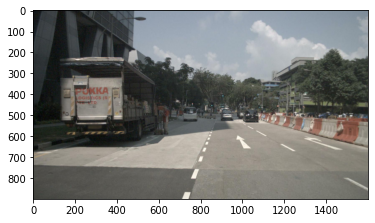

In [45]:
image= plt.imread(file_name)
fig,ax = plt.subplots()
ax.imshow(image)
plt.show()

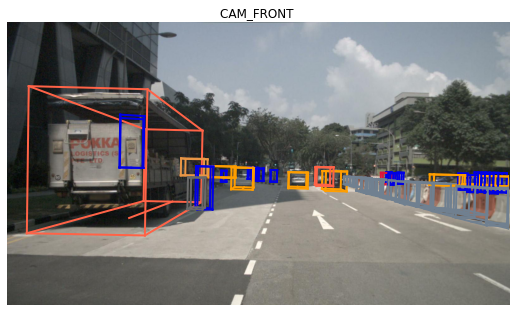

In [54]:
nusc.render_sample_data(cam_data['token'])

In [121]:
import cv2

In [130]:
def drawBoundingBox(imgcv,xmin,xmax,ymin,ymax):
  x1 = int(xmin)
  y1 = int(ymax)
  x2 = int(xmax)
  y2= int(ymin)
  #(x1,y1),(x2,y2) = (xmin,ymax),(xmax,ymin)

        
            # print(x1,y1,x2,y2,conf,label)
  cv2.rectangle(imgcv,(x1,y1),(x2,y2),(0,255,0),6)
  #labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,0.5,2)
            # print('labelSize>>',labelSize)
 # _x1 = x1
  #_y1 = y1#+int(labelSize[0][1]/2)
  #_x2 = _x1
  #_y2 = y1
  #cv2.rectangle(imgcv,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
  #cv2.putText(imgcv,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
  return imgcv 

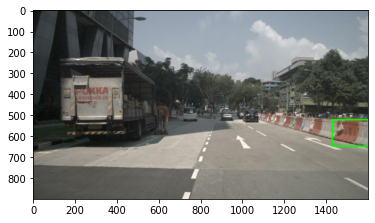

In [132]:
 image= plt.imread(file_name)
 image = cv2.UMat(image).get()
 bx = drawBoundingBox(image,xmin,xmax,ymin,ymax)
 plt.imshow(bx)

# **RADAR CHANNEL FORMATION**


